In [1]:
import networkx as nx

from collections.abc import Iterable

# flatten Graph
def flatten(l):
    for el in l:
        if isinstance(el, Iterable) and not isinstance(el, (str, bytes)):
            yield from flatten(el)
        else:
            yield el


# generate task
def generateTask(maxNumberOfTasks):
    import networkx as nx
    import random
    listOfNodes = list(range(1,maxNumberOfTasks+1))
    listOfEdges = []
    adjancyList = {}
    adjancyList[listOfNodes[-1]] = []
    for i in listOfNodes[:-1]:
        a = random.random()
        numbersInLayer = round(a/i * maxNumberOfTasks)
        maxNumber = i+numbersInLayer
        if maxNumber > maxNumberOfTasks:
            maxNumber = maxNumberOfTasks
        potentialChildNodes = list(range(i+2, maxNumber))

        childNodes = potentialChildNodes

        valInLists = list(flatten(list(adjancyList.values())))

        if (i+1) not in valInLists:
            listOfEdges.append([i, i+1])
            potentialChildNodes.append(i+1)
            
        adjancyList[i] = childNodes
        #adjancyList[i].append(i+1)
        #listOfEdges.append([i, i+1])
        for j in childNodes:
            listOfEdges.append([i,j])

    G = nx.DiGraph()
    G.add_edges_from(listOfEdges)

    for node in list(G.nodes()):
        if not nx.has_path(G,node,maxNumberOfTasks):
            adjancyList[node].append(maxNumberOfTasks)
            listOfEdges.append([node,maxNumberOfTasks])
    
    #print(adjancyList)
    
    G.add_edges_from(listOfEdges)
    return G

This graph is DAG? True


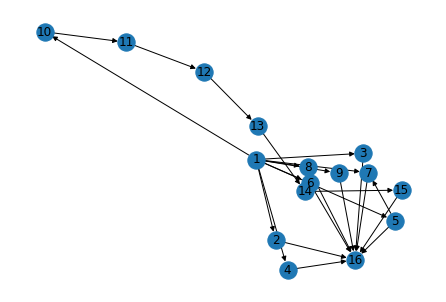

In [2]:
numbersOfTasks = 16
G = generateTask(numbersOfTasks)
print("This graph is DAG?",nx.is_directed_acyclic_graph(G)) # check if graph is DAG
nx.draw(G, with_labels = True) # draw

In [3]:
# будем роаспределять задания по машинам
numberOfMachines = 4
CPUOfTask = 100
memoryOfTask = 20


CPU = [8,16,64, 96]
memory = [16,32,64,128, 256]
HDD = [475,600,2400,3600]

price = [0.3616, 0.824, 3.616, 5.712]


class setOfMachines():
    setMachines = []

    def __init__(self, numbersOfMachines):
        self.numbersOfMachines = numbersOfMachines
        self.setFreeMachines = []
        self.setMachines = []


    def addMachines(self, machine):
        self.setMachines.append(machine)
        
    def setOfFreeMachines(self, currentTime):
        self.setFreeMachines = []
        for i in self.setMachines:
            if i.availability == "free" and i.timeOfDeliverance < currentTime:
                self.setFreeMachines.append(i)
        return self.setFreeMachines
    
    def freeMachineWithBestCPUWithRequiredMemory(self, requiredMemory, currentTime):
        bestCPU = 0
        for i in self.setMachines:
            if i.availability == "free" and i.timeOfDeliverance < currentTime and i.CPU > bestCPU:
                machineWithBestCPU = i
                bestCPU = i.CPU
        return machineWithBestCPU
        
    def averageValuesOfFreeMachines(self):
        
        averageCPU = sum([i.CPU for i in self.setMachines]) / len(self.setMachines)
        averageMemory = sum([i.memory for i in self.setMachines]) / len(self.setMachines)
        averageHDD = sum([i.HDD for i in self.setMachines]) / len(self.setMachines)

        return averageCPU, averageMemory, averageHDD
    
    def priceOfAllAvailableMachines(self):
        commonPriceOfAllMachines = sum([i.price for i in self.setMachines])
        return commonPriceOfAllMachines
    
    def assignMachineBusy(self, numberOfMachine):
        self.setMachines[numberOfMachine].availability = "busy"
    def assignMachineFree(self, numberOfMachine, timeOfDeliv):
        self.setMachines[numberOfMachine].availability = "free"
        self.setMachines[numberOfMachine].timeOfDeliverance = timeOfDeliv

         
    

    
    
class machine():
    def name(self, name):
        self.name = name
    def CPU(self, CPU):
        self.CPU = CPU
    def memory(self, memory):
        self.memory = memory
    def HDD(self, HDD):
        self.HDD = HDD
    def availability(self, available):
        self.available = available
    def price(self, price):
        self.price = price
    def timeOfDeliverance(self, timeOfDeliverance):
        self.timeOfDeliverance = timeOfDeliverance
        
import random


numberOfMachines = 4
setOfAllMachines = setOfMachines(4)


# generate parameters of machines
for i in range(numberOfMachines):
    a = random.random()
    b = random.random()
    c = random.random()
    
    m1 = machine()
    m1.name = i
    m1.CPU = CPU[round(a * (len(CPU) - 1))]
    m1.memory = memory[round(b * (len(memory) - 1))]
    m1.HDD =  HDD[round(c * (len(HDD) - 1))]
    m1.availability = "free"
    m1.price = price[round(a * (len(price) - 1))]
    m1.timeOfDeliverance = -2
    setOfAllMachines.addMachines(m1)
    
# берем первое задание и кладем его в на самы йлучший компьютер, потому что без выполненного первого задания другие не могут выполняться, поэтому нужна максчимальная скорость выполненения

In [4]:
def calculateThePartsOfTask(G):
    dTree = {}
    dTree[1] = 1
    for node in G.nodes():
        childNodes = list(G.neighbors(node))
        if len(childNodes) != 0:
            for child in childNodes:
                if child in dTree:
                    dTree[child] += dTree[node] / len(childNodes)
                else:
                    dTree[child] = dTree[node] / len(childNodes)
    return dTree

def calculationOfExecutionTime(cpuOfTask, cpuOfMachine, MemoryOfTask, HDDOfMachine): # считаем время выполнения задачи на определнной машине
    executionTime = cpuOfTask*10/cpuOfMachine + MemoryOfTask/HDDOfMachine
    return executionTime

In [5]:
# for first node 1
partOfTask = calculateThePartsOfTask(G)


dictTimeDone = {}
for i in G.nodes():
    dictTimeDone[i] = {"done":"No","start":None, "finish":None, "nameOfMachine":None, "outMemory":None, "partOfTask" :partOfTask[i]}

commonTime = 0
dictTimeDone[1]["start"] = commonTime
requiredMemory = memoryOfTask * partOfTask[1]
bestFreeMachine= setOfAllMachines.freeMachineWithBestCPUWithRequiredMemory(0, commonTime)
setOfAllMachines.assignMachineBusy(bestFreeMachine.name)
executedTime = calculationOfExecutionTime(CPUOfTask * partOfTask[1], bestFreeMachine.CPU, memoryOfTask * partOfTask[1], bestFreeMachine.HDD)
commonTime += executedTime
dictTimeDone[1]["finish"] = commonTime
dictTimeDone[1]["nameOfMachine"] = bestFreeMachine.name
dictTimeDone[1]["done"] = "Yes"
dictTimeDone[1]["outMemory"] = requiredMemory + 5
setOfAllMachines.assignMachineFree(bestFreeMachine.name, commonTime)



In [6]:
def findMachineAndExecuteTask(indexOfTask, currentTime, dictTimeDone, setOfAllMachines):

    dictTimeDone[indexOfTask]["start"] = currentTime
    requiredMemory = memoryOfTask * partOfTask[indexOfTask]
    bestFreeMachine= setOfAllMachines.freeMachineWithBestCPUWithRequiredMemory(0, currentTime)
    #print(bestFreeMachine)
    while bestFreeMachine == None:
        bestFreeMachine = setOfAllMachines.freeMachineWithBestCPUWithRequiredMemory(0, currentTime)
        currentTime += 1
    #print("bestFreeMachine", bestFreeMachine)
    setOfAllMachines.assignMachineBusy(bestFreeMachine.name)
    executedTime = calculationOfExecutionTime(CPUOfTask * partOfTask[indexOfTask], bestFreeMachine.CPU, memoryOfTask * partOfTask[indexOfTask], bestFreeMachine.HDD)
    #print(executedTime, CPUOfTask * partOfTask[indexOfTask])
    currentTime += executedTime
    dictTimeDone[indexOfTask]["finish"] = currentTime
    dictTimeDone[indexOfTask]["nameOfMachine"] = bestFreeMachine.name
    dictTimeDone[indexOfTask]["done"] = "Yes"
    dictTimeDone[indexOfTask]["outMemory"] = requiredMemory + 5
    setOfAllMachines.assignMachineFree(bestFreeMachine.name, currentTime)  

    return currentTime # передается время освобождения

In [7]:
def distributionTaskToMachines(prioritet, commonTime, dictTimeDone,setOfAllMachines):
    from queue import PriorityQueue
    q = PriorityQueue()
    for task in prioritet:
        q.put((-dictTimeDone[task]["partOfTask"], task))
    #print(q)
    while not q.empty():
            while len(setOfAllMachines.setOfFreeMachines(commonTime)) < 1:
                    commonTime += 1
                    #print("commonTime+1", commonTime)
            #print(len(setOfAllMachines.setOfFreeMachines(commonTime)))
            for o in range(len(setOfAllMachines.setOfFreeMachines(commonTime))):
                if not q.empty():
                    next_item = q.get()
                    #print(next_item)
                    currentTime = commonTime
                    findMachineAndExecuteTask(next_item[1], currentTime, dictTimeDone, setOfAllMachines)
                    #print("1")

            #print("commonTime", commonTime)
    return commonTime

In [8]:
# select child of first node can be execited, because theurs parents tasks is completed

for i in G.nodes():
    print(i)
    firstPrioritet = set()
    secondPrioritet = set()
    for node in list(G.neighbors(i)):
        if dictTimeDone[node]["done"] != "Yes":
            execParentTask = list(filter(lambda parent: dictTimeDone[parent]["done"] == "No", list(G.predecessors(node))))
            if len(execParentTask) > 0:
                firstPrioritet.update(execParentTask)
                secondPrioritet.add(node)
            else:
                firstPrioritet.add(node)
            #print(firstPrioritet)
    
    if len(firstPrioritet) > 0:
        commonTime = distributionTaskToMachines(firstPrioritet, commonTime, dictTimeDone, setOfAllMachines)
    if len(secondPrioritet) > 0:
        commonTime = distributionTaskToMachines(secondPrioritet, commonTime, dictTimeDone, setOfAllMachines)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [9]:
def distributionTaskToMachines(prioritet, commonTime, dictTimeDone, setOfAllMachines):
    from queue import PriorityQueue
    q = PriorityQueue()
    for task in prioritet:
        q.put((-dictTimeDone[task]["partOfTask"], task))
    #print(q)
    while not q.empty():
            while len(setOfAllMachines.setOfFreeMachines(commonTime)) < 1:
                    commonTime += 1
                    #print("commonTime+1", commonTime)
            #print(len(setOfAllMachines.setOfFreeMachines(commonTime)))
            for o in range(len(setOfAllMachines.setOfFreeMachines(commonTime))):
                if not q.empty():
                    next_item = q.get()
                    #print(next_item)
                    currentTime = commonTime
                    findMachineAndExecuteTask(next_item[1], currentTime, dictTimeDone, setOfAllMachines)
                    #print("1")

            #print("commonTime", commonTime)
    return commonTime

In [10]:
def distribitionTaskInMachines(numberOfMachines,CPUOfTask,memoryOfTask, G):
    
    
    allMachines = setOfMachines(numberOfMachines)

    # generate parameters of machines
    for i in range(numberOfMachines):
        a = random.random()
        b = random.random()
        c = random.random()

        m1 = machine()
        m1.name = i
        m1.CPU = CPU[round(a * (len(CPU) - 1))]
        m1.memory = memory[round(b * (len(memory) - 1))]
        m1.HDD =  HDD[round(c * (len(HDD) - 1))]
        m1.availability = "free"
        m1.price = price[round(a * (len(price) - 1))]
        m1.timeOfDeliverance = -2
        allMachines.addMachines(m1)
    

    # for first node 1
    partOfTask = calculateThePartsOfTask(G)
    
    numberOfMachines = len(allMachines.setMachines)
    print(numberOfMachines)

    dictTimeDone = {}
    for i in G.nodes():
        dictTimeDone[i] = {"done":"No","start":None, "finish":None, "nameOfMachine":None, "outMemory":None, "partOfTask" :partOfTask[i]}

    commonTime = 0
    dictTimeDone[1]["start"] = commonTime
    requiredMemory = memoryOfTask * partOfTask[1]
    bestFreeMachine= allMachines.freeMachineWithBestCPUWithRequiredMemory(0, commonTime)
    allMachines.assignMachineBusy(bestFreeMachine.name)
    executedTime = calculationOfExecutionTime(CPUOfTask * partOfTask[1], bestFreeMachine.CPU, memoryOfTask * partOfTask[1], bestFreeMachine.HDD)
    commonTime += executedTime
    dictTimeDone[1]["finish"] = commonTime
    dictTimeDone[1]["nameOfMachine"] = bestFreeMachine.name
    dictTimeDone[1]["done"] = "Yes"
    dictTimeDone[1]["outMemory"] = requiredMemory + 5
    allMachines.assignMachineFree(bestFreeMachine.name, commonTime)
    
    # select child of first node can be execited, because theurs parents tasks is completed

    for i in G.nodes():
        #print(i)
        firstPrioritet = set()
        secondPrioritet = set()
        for node in list(G.neighbors(i)):
            if dictTimeDone[node]["done"] != "Yes":
                execParentTask = list(filter(lambda parent: dictTimeDone[parent]["done"] == "No", list(G.predecessors(node))))
                if len(execParentTask) > 0:
                    firstPrioritet.update(execParentTask)
                    secondPrioritet.add(node)
                else:
                    firstPrioritet.add(node)
                #print(firstPrioritet)

        if len(firstPrioritet) > 0:
            commonTime = distributionTaskToMachines(firstPrioritet, commonTime, dictTimeDone, allMachines)
        if len(secondPrioritet) > 0:
            commonTime = distributionTaskToMachines(secondPrioritet, commonTime, dictTimeDone, allMachines)
            
    return dictTimeDone

In [11]:
resultDict = distribitionTaskInMachines(5,100,memoryOfTask, G)

5


In [12]:
commonPrice = 0
for key, value in resultDict.items():
    commonPrice += (value["finish"] - value["start"]) * price[value["nameOfMachine"]-1]
print("commonPrice", commonPrice)


commonTime = max(int(d['finish']) for d in resultDict.values())
print("commonTime", commonTime)


for key, value in resultDict.items():
    print(value["start"], value["finish"], value["nameOfMachine"])

commonPrice 268.96906365172197
commonTime 27
0 10.458771929824561 4
10.458771929824561 12.195808966861598 0
10.458771929824561 17.40414230019493 1
10.458771929824561 17.407894736842106 3
10.458771929824561 24.348278102664068 2
11.458771929824561 12.620857699805068 4
15.458771929824561 17.20190058479532 4
12.458771929824561 14.195808966861598 0
13.458771929824561 14.620857699805068 4
14.458771929824561 16.1958089668616 0
17.45877192982456 24.40414230019493 1
17.45877192982456 24.407894736842106 3
18.45877192982456 20.1958089668616 0
20.45877192982456 22.1958089668616 0
16.45877192982456 18.1958089668616 0
17.45877192982456 27.917543859649122 4
